In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from os.path import join

plt.style.use(["seaborn", "thesis"])

/home/jcartus/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Fetch Dataset 

In [7]:
from SCFInitialGuess.utilities.dataset import extract_triu_batch, AbstractDataset
from sklearn.model_selection import train_test_split
from pyscf.scf import hf

data_path = "../../dataset/TSmall_sto3g"
postfix = "TSmall_sto3g"
dim = 26
#data_path = "../../../butadien/data/"
#postfix = ""
#dim = 26


def split(x, y, ind):
    return x[:ind], y[:ind], x[ind:], y[ind:]

S = np.load(join(data_path, "S" + postfix + ".npy"))
P = np.load(join(data_path, "P" + postfix + ".npy"))
F = np.load(join(data_path, "F" + postfix + ".npy"))

index = np.load(join(data_path, "index" + postfix + ".npy"))


ind = int(0.8 * len(index))

molecules = np.load(join(data_path, "molecules" + postfix + ".npy"))
molecules = (molecules[:ind], molecules[ind:])



s_triu_norm, mu, std = AbstractDataset.normalize(S)

h_test = [hf.get_hcore(mol.get_pyscf_molecule()) for mol in molecules[1]]

s_train, f_train, s_test, f_test = split(S.reshape(-1, dim, dim), F.reshape(-1, dim, dim), ind)

FileNotFoundError: [Errno 2] No such file or directory: '../../cc2ai/ethen/Sethen_6-31g**.npy'

In [15]:
from SCFInitialGuess.utilities.dataset import extract_triu_batch, AbstractDataset
from sklearn.model_selection import train_test_split
from pyscf.scf import hf

data_path = "/home/jcartus/Repos/SCFInitialGuess/cc2ai/ethen/"
postfix = "_ethen_6-31g**"
dim = 48
#data_path = "../../dataset/TSmall_sto3g"
#postfix = "TSmall_sto3g"
#dim = 26
#data_path = "../../../butadien/data/"
#postfix = ""
#dim = 26


def split(x, y, ind):
    return x[:ind], y[:ind], x[ind:], y[ind:]

S, P = np.load(join(data_path, "dataset" + postfix + ".npy"))
#F = np.load(join(data_path, "F" + postfix + ".npy"))

#index = np.load(join(data_path, "index" + postfix + ".npy"))


ind = int(0.8 * len(S))

molecules = np.load(join(data_path, "molecules" + postfix + ".npy"))
molecules = (molecules[:ind], molecules[ind:])



h_test = [hf.get_hcore(mol.get_pyscf_molecule()) for mol in molecules[1]]

s_triu_norm, mu, std = AbstractDataset.normalize(S)

s_train, p_train, s_test, p_test = split(S.reshape(-1, dim, dim), P.reshape(-1, dim, dim), ind)

In [27]:
def fock_from_density(p_batch):
    f = []
    for p, s, h, mol in zip(p_batch, s_test, h_test, molecules[1]):
        f.append(hf.get_fock(h, s, hf.get_veff(mol.get_pyscf_molecule(), p), p))
    return np.array(f)

f_test = fock_from_density(p_test)

In [28]:
f_test.shape

(40, 48, 48)

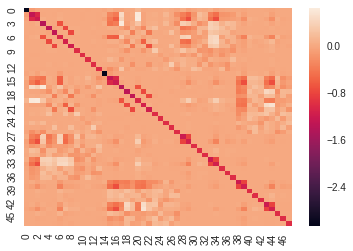

In [29]:
import seaborn as sns

sns.heatmap(-1 *f_test[0].reshape(dim, dim))

# Pure blocks

i will now set all other elements zero

## Utilities

In [18]:
from SCFInitialGuess.utilities.constants import number_of_basis_functions as N_BASIS

mol = molecules[0][0]

mask = np.zeros((dim, dim))

current_dim = 0
for atom in mol.species:
    
    # calculate block range
    index_start = current_dim
    current_dim += N_BASIS["sto-3g"][atom] 
    index_end = current_dim
    
    # calculate logical vector
    L = np.arange(dim)
    L = np.logical_and(index_start <= L, L < index_end)
    
    m = np.logical_and.outer(L, L)
    mask = np.logical_or(mask, m)
    
#mask

In [19]:
from pyscf.scf import hf

def density_from_fock(f, s, mol):
    
    mo_energy, mo_coeff = hf.eig(f, s)
    mo_occ = hf.get_occ(hf.SCF(mol), mo_energy, mo_coeff)
    
    return hf.make_rdm1(mo_coeff, mo_occ)

def density_from_fock_batch(f_batch):
    p = []
    for (s, f, mol) in zip(s_test, f_batch, molecules[1]):
        p.append(density_from_fock(f, s, mol.get_pyscf_molecule()))
    return np.array(p)

In [30]:
from SCFInitialGuess.utilities.dataset import reconstruct_from_triu

def extract_pure(p):
    p_batch = p.copy()
    p_batch[np.logical_not(mask)] = 0.0
    return p_batch

f_pure = np.array(list(map(extract_pure, f_test))).astype("float64")

In [31]:
p_pure = density_from_fock_batch(f_pure)

In [34]:
from SCFInitialGuess.utilities.analysis import make_results_str, measure_all_quantities
from SCFInitialGuess.utilities.dataset import StaticDataset

N_ELECTRONS = 16

dataset = StaticDataset(
    train=(s_train, p_train),
    validation=(None, None),
    test=(s_test, p_test),
    mu=mu,
    std=std
)


## Pure Block Analysis 

In [35]:
from SCFInitialGuess.utilities.analysis import mf_initializer as mf_initializer


print(make_results_str(measure_all_quantities(
    p_pure,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

[ ] 2018-10-05 14:02:30: Iteration calculation: 0
[ ] 2018-10-05 14:02:31: Iteration calculation: 1
[ ] 2018-10-05 14:02:32: Iteration calculation: 2
[ ] 2018-10-05 14:02:33: Iteration calculation: 3
[ ] 2018-10-05 14:02:35: Iteration calculation: 4
[ ] 2018-10-05 14:02:36: Iteration calculation: 5
[ ] 2018-10-05 14:02:38: Iteration calculation: 6
[ ] 2018-10-05 14:02:39: Iteration calculation: 7
[ ] 2018-10-05 14:02:40: Iteration calculation: 8
[ ] 2018-10-05 14:02:41: Iteration calculation: 9
[ ] 2018-10-05 14:02:43: Iteration calculation: 10
[ ] 2018-10-05 14:02:44: Iteration calculation: 11
[ ] 2018-10-05 14:02:45: Iteration calculation: 12
[ ] 2018-10-05 14:02:46: Iteration calculation: 13
[ ] 2018-10-05 14:02:48: Iteration calculation: 14
[ ] 2018-10-05 14:02:49: Iteration calculation: 15
[ ] 2018-10-05 14:02:50: Iteration calculation: 16
[ ] 2018-10-05 14:02:51: Iteration calculation: 17
[ ] 2018-10-05 14:02:52: Iteration calculation: 18
[ ] 2018-10-05 14:02:54: Iteration calcul

# Embedding the Blocks In Classical Guesses

In [36]:
from pyscf.scf import hf

p_sad = np.array([
    hf.init_guess_by_atom(mol.get_pyscf_molecule()) for mol in molecules[1]
]).astype("float64")

In [40]:
f_sad = fock_from_density(p_sad)

In [41]:
from SCFInitialGuess.utilities.dataset import reconstruct_from_triu

def embedd(x):
    p = x[1].copy()
    p[mask] = (x[0].copy())[mask]
    return p

f_embedded_sad = np.array(list(map(embedd, zip(f_test, f_sad))))

In [42]:
p_embedded_sad = density_from_fock_batch(f_embedded_sad)

## SAD

In [43]:
print(make_results_str(measure_all_quantities(
    p_embedded_sad,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

[ ] 2018-10-05 14:05:56: Iteration calculation: 0
[ ] 2018-10-05 14:05:57: Iteration calculation: 1
[ ] 2018-10-05 14:05:59: Iteration calculation: 2
[ ] 2018-10-05 14:06:01: Iteration calculation: 3
[ ] 2018-10-05 14:06:02: Iteration calculation: 4
[ ] 2018-10-05 14:06:02: Iteration calculation: 5
[ ] 2018-10-05 14:06:03: Iteration calculation: 6
[ ] 2018-10-05 14:06:04: Iteration calculation: 7
[ ] 2018-10-05 14:06:05: Iteration calculation: 8
[ ] 2018-10-05 14:06:07: Iteration calculation: 9
[ ] 2018-10-05 14:06:08: Iteration calculation: 10
[ ] 2018-10-05 14:06:09: Iteration calculation: 11
[ ] 2018-10-05 14:06:11: Iteration calculation: 12
[ ] 2018-10-05 14:06:12: Iteration calculation: 13
[ ] 2018-10-05 14:06:13: Iteration calculation: 14
[ ] 2018-10-05 14:06:13: Iteration calculation: 15
[ ] 2018-10-05 14:06:14: Iteration calculation: 16
[ ] 2018-10-05 14:06:16: Iteration calculation: 17
[ ] 2018-10-05 14:06:18: Iteration calculation: 18
[ ] 2018-10-05 14:06:19: Iteration calcul

## GWH

In [57]:
f_gwh = []

k = np.ones((dim, dim)) * 1.75 - \
            np.diag(np.ones(dim)) * 0.75  

for h,s in zip(h_test, s_test):
    h_diag = np.diag(h)   
        
    f_gwh.append(k * np.add.outer(h_diag, h_diag) * s / 2)
    
f_gwh = np.array(f_gwh)

In [60]:
f_embedded_gwh = np.array(list(map(embedd, zip(f_test, f_gwh))))

In [61]:
p_embedded_gwh = density_from_fock_batch(f_embedded_gwh)

In [63]:
print(make_results_str(measure_all_quantities(
    p_embedded_gwh,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

[ ] 2018-10-05 14:17:23: Iteration calculation: 0
[ ] 2018-10-05 14:17:24: Iteration calculation: 1
[ ] 2018-10-05 14:17:25: Iteration calculation: 2
[ ] 2018-10-05 14:17:26: Iteration calculation: 3
[ ] 2018-10-05 14:17:27: Iteration calculation: 4
[ ] 2018-10-05 14:17:29: Iteration calculation: 5
[ ] 2018-10-05 14:17:30: Iteration calculation: 6
[ ] 2018-10-05 14:17:31: Iteration calculation: 7
[ ] 2018-10-05 14:17:33: Iteration calculation: 8
[ ] 2018-10-05 14:17:34: Iteration calculation: 9
[ ] 2018-10-05 14:17:36: Iteration calculation: 10
[ ] 2018-10-05 14:17:37: Iteration calculation: 11
[ ] 2018-10-05 14:17:38: Iteration calculation: 12
[ ] 2018-10-05 14:17:39: Iteration calculation: 13
[ ] 2018-10-05 14:17:41: Iteration calculation: 14
[ ] 2018-10-05 14:17:42: Iteration calculation: 15
[ ] 2018-10-05 14:17:44: Iteration calculation: 16
[ ] 2018-10-05 14:17:46: Iteration calculation: 17
[ ] 2018-10-05 14:17:47: Iteration calculation: 18
[ ] 2018-10-05 14:17:49: Iteration calcul

# Test 

In [ ]:
from SCFInitialGuess.utilities.dataset import make_matrix_batch
s_test_batch = make_matrix_batch(S[ind:], dim)

In [ ]:
from SCFInitialGuess.nn.post_processing import multi_mc_wheeny
from SCFInitialGuess.utilities.dataset import make_matrix_batch

#del p_embedded_sad
#del p_sad
#del p_gwh
#del P
#del dataset
#del molecules
#del p_pure
#del s_train
#del p_train

f = lambda x: multi_mc_wheeny(x[0], x[1], 20)

p_embedded_gwh_mcw5 = np.array(list(map(f, zip(p_embedded_gwh, s_test_batch))))

In [ ]:
from SCFInitialGuess.utilities.analysis import mf_initializer

print(make_results_str(measure_all_quantities(
    p_embedded_gwh_mcw5,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=True,
    s=S[ind:]
)))